In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
import json
import random
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [4]:
def readData():
    dataFolder = "./data/"
    files = os.listdir(dataFolder)
    data = []
    for file in files:
        path = dataFolder + file
        with open(path, "r") as f:
            raw = f.read()
            raw = raw.split("\n")
            for singleRaw in raw[:-1]:
                datapoint = json.loads(singleRaw)
                readings = datapoint["data"]
                hz = len(readings) / ((readings[-1][0] - readings[0][0]) * 10**-9)  # timestamp is in nanoseconds
                if (hz > 40):
                    data += [datapoint]
    return data

data = readData()

In [5]:

def normalise(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset-mu) / sigma

def convertData(data):
    X, T, truth, misc = [], [], [], []
    for d in data:
        id = d["id"]
        drunk = d["drunk"]
        walking = d["walking"]
        readings = d["data"]
        firstTimestamp = readings[0][0]
        convertedReadings = []
        timestamps = []
        for r in readings:
            t, x, y, z = r
            timestamp = t - firstTimestamp  # slide so all timestamps start at 0
            if timestamp < 30 * 10**9 and len(convertedReadings)<1200:
                convertedReadings += [ [x, y, z] ]
                timestamps += [t]
            if timestamp < 0:
                break
        else:
            if len(convertedReadings) == 1200:
                X += [normalise(np.array(convertedReadings))]
                T += [timestamps]
                truth += [drunk]
                misc += [id, walking]
    X = np.array(X)
    T = np.array(T)
    truth = np.array(truth).astype(int)
    truthOnehot = np.zeros((truth.size, 2))
    truthOnehot[np.arange(truth.size), truth] = 1
    misc = np.array(misc)
    return X, T, truthOnehot, misc



X, T, y, misc = convertData(data)

In [6]:
def getTrainTestSplit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = getTrainTestSplit(X, y)


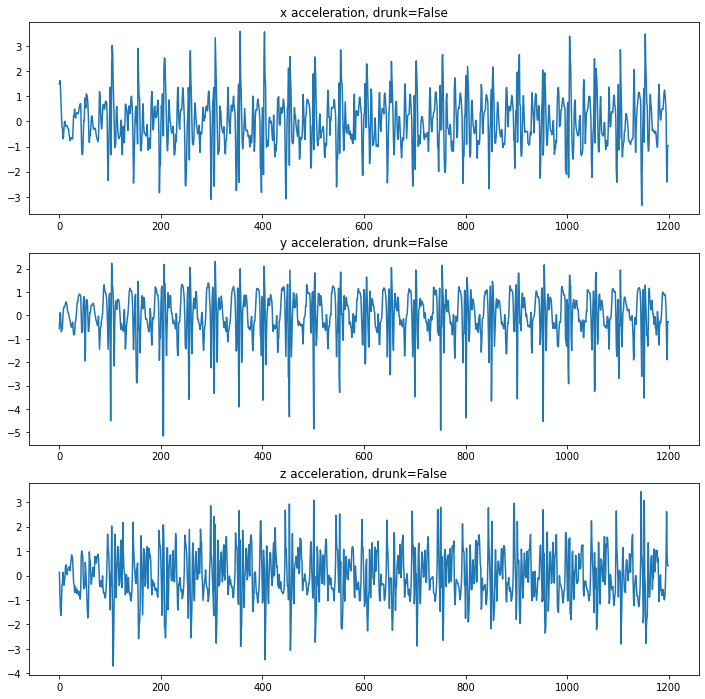

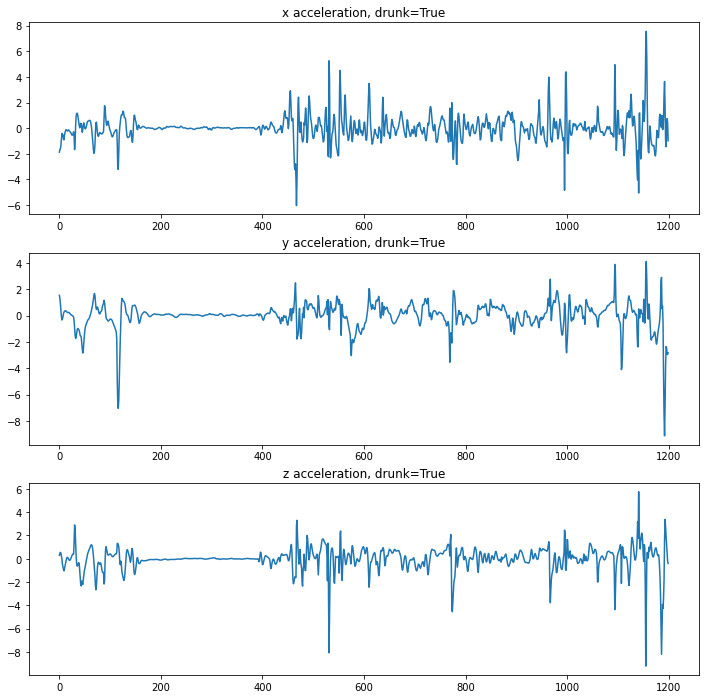

In [7]:
def plot(ax, y, title):
    ax.plot([i for i in range(len(y))], y)
    ax.set_title(title)
    #ax.title = title

def plotdata(X, T, y):
    for option in range(y.shape[1]):
        series = random.choice(X[y.T[option]==1])
        fig, axes = plt.subplots(nrows=3, figsize=(12,12))
        for ax, vals, label in zip(axes, series.T, "xyz"):
            plot(ax, vals, f"{label} acceleration, drunk={option==1}")

plotdata(X, T, y)



In [8]:
def trainModel(X, y):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X, y, epochs=6, batch_size=32)

    return model

model = trainModel(X_train, y_train)
model.evaluate(X_test, y_test, batch_size=32, verbose=0)

Epoch 1/6
6/6 [==============================] - 2s 91ms/step - loss: 2.4764 - accuracy: 0.7978
Epoch 2/6
6/6 [==============================] - 0s 78ms/step - loss: 0.3790 - accuracy: 0.7705
Epoch 3/6
6/6 [==============================] - 0s 75ms/step - loss: 0.2352 - accuracy: 0.8689
Epoch 4/6
6/6 [==============================] - 0s 74ms/step - loss: 0.0976 - accuracy: 0.9891
Epoch 5/6
6/6 [==============================] - 0s 74ms/step - loss: 0.0591 - accuracy: 1.0000
Epoch 6/6
6/6 [==============================] - 0s 74ms/step - loss: 0.0284 - accuracy: 1.0000


[0.2896094024181366, 0.804347813129425]

In [9]:
def summarize_results(scores):
	print(scores)
	m, s = np.mean(scores), np.std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(X_train, y_train, X_test, y_test, repeats=10):
	# repeat experiment
	scores = list()
	for r in range(repeats):
		model = trainModel(X_train, y_train)
		_, score = model.evaluate(X_test, y_test)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

# run the experiment
run_experiment(X_train, y_train, X_test, y_test)

Epoch 1/6
6/6 [==============================] - 1s 82ms/step - loss: 1.7392 - accuracy: 0.7104
Epoch 2/6
6/6 [==============================] - 0s 81ms/step - loss: 0.4731 - accuracy: 0.8470
Epoch 3/6
6/6 [==============================] - 0s 82ms/step - loss: 0.1698 - accuracy: 0.9454
Epoch 4/6
6/6 [==============================] - 0s 80ms/step - loss: 0.1055 - accuracy: 1.0000
Epoch 5/6
6/6 [==============================] - 0s 80ms/step - loss: 0.0496 - accuracy: 0.9945
Epoch 6/6
2/2 [==============================] - 0s 8ms/step - loss: 0.1700 - accuracy: 0.8913
>#1: 89.130
Epoch 1/6
6/6 [==============================] - 1s 78ms/step - loss: 1.9460 - accuracy: 0.7760
Epoch 2/6
6/6 [==============================] - 0s 75ms/step - loss: 0.3515 - accuracy: 0.8634
Epoch 3/6
6/6 [==============================] - 0s 81ms/step - loss: 0.2320 - accuracy: 0.8689
Epoch 4/6
6/6 [==============================] - 0s 74ms/step - loss: 0.1350 - accuracy: 0.9727
Epoch 5/6
6/6 [==============